## feature ranking with elimination

In [1]:
import csv
import time  # Just to compare fit times
from pathlib import Path
from pprint import pprint
import csv
import multiprocessing

In [2]:
import numpy as np
# import xgboost as xgb
# from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import dask.dataframe as dd
import xgboost as xgb
# from tune_sklearn import TuneSearchCV
# from xgboost import XGBRegressor
# import xgboost as xgb


In [3]:
input_dataset_path = Path('input_dataset_filtered.csv')

In [5]:
%%time

# read the csv file created
train = np.genfromtxt(input_dataset_path, delimiter=',',skip_header=1)


X, y = train[:, 1:], train[:, :1]
y = y.ravel()

# Set training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

CPU times: user 14.4 s, sys: 866 ms, total: 15.3 s
Wall time: 15.3 s


In [19]:
headers = next(csv.reader(open(input_dataset_path)))
pprint(headers)

['target',
 '/g/data/ge3/sheece/LOC_distance_to_coast.tif',
 '/g/data/ge3/sheece/mrvbf_9.tif',
 '/g/data/ge3/sheece/relief_mrvbf_3s_mosaic.tif',
 '/g/data/ge3/sheece/relief_elev_focalrange1000m_3s.tif',
 '/g/data/ge3/sheece/relief_elev_focalrange300m_3s.tif',
 '/g/data/ge3/sheece/saga_wetSM_85_resampled.tif',
 '/g/data/ge3/sheece/tpi_300.tif',
 '/g/data/ge3/sheece/slope_fill2.tif',
 '/g/data/ge3/sheece/dem_fill.tif',
 '/g/data/ge3/sheece/3dem_mag2.tif',
 '/g/data/ge3/sheece/3dem_mag1_fin.tif',
 '/g/data/ge3/sheece/3dem_mag0.fin.tif',
 '/g/data/ge3/sheece/relief_roughness.tif',
 '/g/data/ge3/sheece/LATITUDE_GRID1_clip.tif',
 '/g/data/ge3/sheece/LATITUDE_GRID1_clip.tif',
 '/g/data/ge3/sheece/Dose_2016.tif',
 '/g/data/ge3/sheece/Potassium_2016.tif',
 '/g/data/ge3/sheece/Thorium_2016.tif',
 '/g/data/ge3/sheece/Rad2016U_Th.tif',
 '/g/data/ge3/sheece/Rad2016K_Th.tif',
 '/g/data/ge3/sheece/national_Wii_RF_multirandomforest_prediction.tif',
 '/g/data/ge3/sheece/si_geol1.tif',
 '/g/data/ge3/she

## Build-in Recursive feature elimination with cross-validation


Optimal number of features : 26


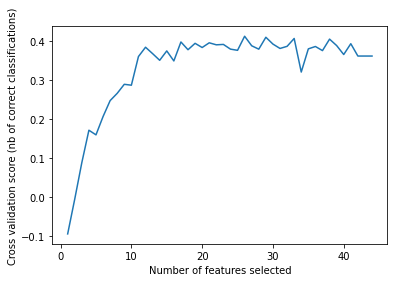

In [112]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV


# Create the RFE object and compute a cross-validated score.
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',n_jobs=90)

# The "accuracy" scoring is proportional to the number of correct
# classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=xgb_model, 
              step=1, 
              cv=2,
              scoring='r2',
              min_features_to_select=min_features_to_select)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select), rfecv.grid_scores_)
plt.show()

In [21]:
rfecv.support_

array([ True,  True,  True,  True, False,  True, False, False,  True,
        True,  True, False, False,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True])

In [22]:
rfecv.ranking_

array([ 1,  1,  1,  1,  4,  1,  7,  8,  1,  1,  1,  9,  2,  1, 11,  1,  1,
        1,  1,  1,  6,  1,  1,  1,  1,  1,  1,  1,  1,  5, 10,  1,  1,  1,
        1,  1,  3,  1,  1,  1,  1,  1,  1,  1])

In [8]:
ranking_ = np.array([ 1,  1,  1,  1,  4,  1,  7,  8,  1,  1,  1,  9,  2,  1, 11,  1,  1,
        1,  1,  1,  6,  1,  1,  1,  1,  1,  1,  1,  1,  5, 10,  1,  1,  1,
        1,  1,  3,  1,  1,  1,  1,  1,  1,  1])
len(ranking_)


headers = next(csv.reader(open(input_dataset_path)))[1:]
len(headers)


unsorteddic = {}
for i, rank in enumerate(ranking_):
        unsorteddic[headers[i]] = rank
sorteddic = dict(sorted(unsorteddic.items(), key=lambda item: item[1]))
sorteddic

{'/g/data/ge3/sheece/LOC_distance_to_coast.tif': 1,
 '/g/data/ge3/sheece/mrvbf_9.tif': 1,
 '/g/data/ge3/sheece/relief_mrvbf_3s_mosaic.tif': 1,
 '/g/data/ge3/sheece/relief_elev_focalrange1000m_3s.tif': 1,
 '/g/data/ge3/sheece/saga_wetSM_85_resampled.tif': 1,
 '/g/data/ge3/sheece/dem_fill.tif': 1,
 '/g/data/ge3/sheece/3dem_mag2.tif': 1,
 '/g/data/ge3/sheece/3dem_mag1_fin.tif': 1,
 '/g/data/ge3/sheece/Dose_2016.tif': 1,
 '/g/data/ge3/sheece/Potassium_2016.tif': 1,
 '/g/data/ge3/sheece/Thorium_2016.tif': 1,
 '/g/data/ge3/sheece/Rad2016U_Th.tif': 1,
 '/g/data/ge3/sheece/Rad2016K_Th.tif': 1,
 '/g/data/ge3/sheece/si_geol1.tif': 1,
 '/g/data/ge3/sheece/ceno_euc_aust1.tif': 1,
 '/g/data/ge3/sheece/Grav_lane_clip.tif': 1,
 '/g/data/ge3/sheece/be-30y-85m-avg-ND-NIR-GREEN.filled.lzw.nodata.tif': 1,
 '/g/data/ge3/sheece/be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata.tif': 1,
 '/g/data/ge3/sheece/be-30y-85m-avg_BLUE+SWIR2.tif': 1,
 '/g/data/ge3/sheece/be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata.t

## In-house Recursive feature elimination

In [10]:
import pandas as pd
import numpy as np
import distributed

import dask
import dask.array as da
import dask.dataframe as dd
from dask.distributed import Client, wait, LocalCluster

from dask_cuda import LocalCUDACluster
from dask_ml.model_selection import train_test_split

import xgboost as xgb

from sklearn.metrics import  explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

# Start cluster and client. This is currently local, although I would like to make this distributed across many nodes.
# cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES='0,1,2,3', threads_per_worker=2)
cluster = LocalCluster(n_workers=90,threads_per_worker=1,dashboard_address='0.0.0.0:8787')
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:40615 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 90 Cores: 90 Memory: 202.48 GB


In [11]:
def find_least_important_feature(current_X,client, complete_result):

    for featureindex,feature_name in enumerate(current_X.columns):
        
        # Feature Matrix    
        current_X_without_feature = current_X.drop(feature_name,axis=1)   
        
        # Prep Training/Testing Dataset
        X_train, X_test, y_train, y_test = train_test_split(current_X_without_feature, y, test_size=0.25, random_state=0, shuffle=False)
        del current_X_without_feature
                
        dtrain = xgb.dask.DaskDMatrix(client=client, data=X_train, label=y_train)
        dtest = xgb.dask.DaskDMatrix(client=client, data=X_test, label=y_test)

        del X_train
        del X_test
        del y_train
        
        # XGBoost model
        xg_reg = xgb.dask.train(client,{'objective': 'reg:squarederror',}, dtrain)
        y_pred = xgb.dask.predict(client, xg_reg, dtest)

        complete_result[current_total_feature][feature_name] = {}
        complete_result[current_total_feature][feature_name]["y_pred"] = y_pred
        complete_result[current_total_feature][feature_name]["y_test"] = y_test

    # evaluate preformaces of all the models

    for feature_name in complete_result[current_total_feature].keys():
        complete_result[current_total_feature][feature_name]["score"] = dask.delayed(scoring_function)(complete_result[current_total_feature][feature_name]["y_test"], complete_result[current_total_feature][feature_name]["y_pred"]).compute()
    
    # calculate the results        
    lowest_feature = None
    lowest_score = 1
    for feature_name in complete_result[current_total_feature].keys():

        if complete_result[current_total_feature][feature_name]["score"] <= lowest_score:
            lowest_score = complete_result[current_total_feature][feature_name]["score"]
            lowest_feature = feature_name

    print(lowest_score,lowest_feature,current_total_feature)
    return lowest_feature
    

In [ ]:
#max(r^2)<=1
scoring_function = [explained_variance_score,
                    mean_absolute_error, 
                    mean_squared_error, 
                    r2_score][3]

df = dd.read_csv('input_dataset_filtered.csv')
X = df.drop("target",axis=1)   # Feature Matrix
y = df["target"]               # Target Variable
del df

min_features_required = 20
complete_result = {}

current_total_feature = X.shape[1]
complete_result[current_total_feature] = {}
lowest_feature = find_least_important_feature(X,client, complete_result)

current_X = X.drop(lowest_feature,axis=1)   
current_total_feature = X.shape[1]
while(current_total_feature>min_features_required):

    complete_result[current_total_feature] = {}
    lowest_feature = find_least_important_feature(current_X,client, complete_result)
    current_X = current_X.drop(lowest_feature,axis=1)
    current_total_feature = current_X.shape[1]
    

0.7216303937114723 /g/data/ge3/sheece/relief_roughness.tif 44
0.7199284506243353 /g/data/ge3/sheece/3dem_mag2.tif 44
0.7092432834527074 /g/data/ge3/sheece/LOC_distance_to_coast.tif 42
0.6843856922516365 /g/data/ge3/sheece/Clim_Prescott_LindaGregory.tif 41
0.6757025570178414 /g/data/ge3/sheece/Rad2016K_Th.tif 40
0.6757025570178414 /g/data/ge3/sheece/LATITUDE_GRID1_clip.tif.1 39
0.6759573968036092 /g/data/ge3/sheece/3dem_mag1_fin.tif 38
0.6645666776477719 /g/data/ge3/sheece/mrvbf_9.tif 37
0.6503904875302643 /g/data/ge3/sheece/dem_fill.tif 36
0.6377520308299883 /g/data/ge3/sheece/relief_mrvbf_3s_mosaic.tif 35
0.6272804901177093 /g/data/ge3/sheece/si_geol1.tif 34
0.6072081884230112 /g/data/ge3/sheece/be-30y-85m-avg-ND-NIR-GREEN.filled.lzw.nodata.tif 33
0.5983901755708594 /g/data/ge3/sheece/clim_WDA_albers.tif 32
0.5913221883462372 /g/data/ge3/sheece/Grav_lane_clip.tif 31
0.5876703935143153 /g/data/ge3/sheece/ceno_euc_aust1.tif 30
0.5791808661396697 /g/data/ge3/sheece/water-85m.tif 29
0.566

In [ ]:
#save results
import pickle

fileObj = open('complete_result_irfec.pkl', 'wb')
pickle.dump(complete_result,fileObj)
fileObj.close()

In [ ]:
## In-house Recursive feature elimination


## Shutdown Cluster

In [ ]:
client = distributed.client._get_global_client()
client

In [ ]:
client.shutdown()


In [17]:
# Open the file in read mode

objectRep = open("complete_result_irfec.pkl", "rb")

 

print("Unpickling...")

# Unpickle the objects

object1 = pickle.load(objectRep)
object1

Unpickling...


{44: {'/g/data/ge3/sheece/LOC_distance_to_coast.tif': {'y_pred': dask.array<concatenate, shape=(122712,), dtype=float32, chunksize=(38724,), chunktype=numpy.ndarray>,
   'y_test': Dask Series Structure:
   npartitions=4
       float64
           ...
           ...
           ...
           ...
   Name: target, dtype: float64
   Dask Name: split, 16 tasks,
   'score': 0.7375330504240738},
  '/g/data/ge3/sheece/mrvbf_9.tif': {'y_pred': dask.array<concatenate, shape=(122712,), dtype=float32, chunksize=(38724,), chunktype=numpy.ndarray>,
   'y_test': Dask Series Structure:
   npartitions=4
       float64
           ...
           ...
           ...
           ...
   Name: target, dtype: float64
   Dask Name: split, 16 tasks,
   'score': 0.7343579005707261},
  '/g/data/ge3/sheece/relief_mrvbf_3s_mosaic.tif': {'y_pred': dask.array<concatenate, shape=(122712,), dtype=float32, chunksize=(38724,), chunktype=numpy.ndarray>,
   'y_test': Dask Series Structure:
   npartitions=4
       float64
    